## All Import Modules

In [1]:
import yfinance as yf
import datetime
import numpy as np
from ta import momentum, trend
import pandas as pd

## MENUPLIATE INPUT DATA

In [2]:

def Main_Dataframe(symbol):
    # ------------------------------------ DAY TIME FRAME -----------------------------------------------------------
    ticker = yf.Ticker(symbol)
    day_df = ticker.history(period=f"80d", interval="1d")
    
    # Reset the index and convert the 'Date' column to date format
    day_df.reset_index(inplace=True)
    day_df['Date'] = day_df['Date'].dt.date
    
    # Calculate technical indicators
    day_df['Day_10EMA'] = trend.EMAIndicator(day_df['Close'], window=10).ema_indicator()
    
    day_df['Day_RSI'] = momentum.RSIIndicator(day_df['Close'], window=3).rsi()
    day_df['Day_RSI_EMA'] = trend.EMAIndicator(day_df['Day_RSI'], window=6).ema_indicator()

    # -----------ADD EXTRA INDICATORS HERE --------------
    day_df['Day_Trend'] = np.select(
    [day_df['Day_10EMA'] > day_df['Day_10EMA'].shift(1),
     day_df['Day_10EMA'] < day_df['Day_10EMA'].shift(1)],
    ['Uptrend', 'Downtrend'],'Sideways')
    # Rename columns and drop unnecessary columns
    day_df.rename(columns={'Open': 'Day_Open', 'High': 'Day_High', 'Low': 'Day_Low', 'Close': 'Day_Close'}, inplace=True)
    day_df.drop(columns=['Volume', 'Dividends', 'Stock Splits','Day_10EMA','Day_RSI'], inplace=True)
    day_df.dropna(inplace=True)

    # ------------------------------------ 5 MIN TIME FRAME -----------------------------------------------------------
    previes_days = 50
    df = ticker.history(period=f"{previes_days}d", interval="5m")
    df.reset_index(inplace=True)
    df['Date'] = df['Datetime'].dt.date
    df['Time'] = df['Datetime'].dt.time
    
    df.drop(columns=['Volume', 'Dividends', 'Stock Splits','Datetime'], inplace=True)
    df.dropna(inplace=True)
    # -----------ADD EXTRA INDICATORS HERE --------------
    df['5EMA'] = trend.EMAIndicator(df['Close'], window=5).ema_indicator()
    df['15EMA'] = trend.EMAIndicator(df['Close'], window=15).ema_indicator()
    df['Candle'] = np.where(df['Close'] > df['Open'], 'Green', 'Red')
    
    df['Prev_5EMA'] = df['5EMA'].shift(1)
    df['Prev_15EMA'] = df['15EMA'].shift(1)

    df['RSI'] = momentum.RSIIndicator(df['Close'], window=3).rsi()
    df['RSI_EMA'] = trend.EMAIndicator(df['RSI'], window=6).ema_indicator()
    
   
    short_ema =trend.EMAIndicator(df["Close"], window=5)
    long_ema = trend.EMAIndicator(df["Close"], window=15)
    
    df["5EMA"] = short_ema.ema_indicator()
    df["15EMA"] = long_ema.ema_indicator()
    
    # Determine the perfect trend based on EMA crossovers
    df["Trend"] = "Sideways"  # Default to Sideways
    df.loc[(df["5EMA"] > df["15EMA"]) & (df["5EMA"].shift(1) <= df["15EMA"].shift(1)), "Trend"] = "Uptrend"
    df.loc[(df["5EMA"] < df["15EMA"]) & (df["5EMA"].shift(1) >= df["15EMA"].shift(1)), "Trend"] = "Downtrend"

    first_candle_high = df.groupby('Date')['High'].first()
    first_candle_low = df.groupby('Date')['Low'].first()
    
    # Create a new column for the first candle's high and low
    df['First_Candle_High'] = df['Date'].map(first_candle_high)
    df['First_Candle_Low'] = df['Date'].map(first_candle_low)

    # ------------------------------------ MERGE DATA FRAME -----------------------------------------------------------
    
    merged_df = day_df.merge(df, on='Date', how='inner')
    merged_df.dropna(inplace=True)
    merged_df['DateTime'] = pd.to_datetime(merged_df['Date'].astype(str) + ' ' + merged_df['Time'].astype(str))
    merged_df.drop(['Date', 'Time'], axis=1, inplace=True)
    return merged_df
    # return day_df
    # return df

data = Main_Dataframe("^NSEI")
# data = Main_Dataframe("HDFCBANK.BO")
# data.tail(5)

In [3]:
all_columsn = ['Day_Open', 'Day_High', 'Day_Low', 'Day_Close', 'Day_RSI_EMA',
        'Open', 'High', 'Low', 'Close', '5EMA', '15EMA',
       'Prev_5EMA', 'Prev_15EMA', 'RSI', 'RSI_EMA', 'First_Candle_High', 'First_Candle_Low']
day_all_columsn = ['Date', 'Day_Open', 'Day_High', 'Day_Low', 'Day_Close', 'Day_RSI_EMA']
# data.iloc[-2]

# Add Signals Columns

In [4]:
def Add_Signals(dfnew):
    df = dfnew.copy()
    df['Signal_Day_RSI'] = np.select([df['Day_RSI_EMA'] <= 30, df['Day_RSI_EMA'] >= 70],['CE', 'PE'],default='0')
    
    df['Signal_RSI'] = np.select([df['RSI_EMA'] <= 40, df['RSI_EMA'] >= 60],['CE', 'PE'],default='0')

    ce_5ema = (df['High'].shift(1) < df['5EMA'].shift(1)) & (df['Close'] >= df['5EMA'])
    pe_5ema = (df['Low'].shift(1) > df['5EMA'].shift(1)) & (df['Close'] <= df['5EMA'])
    
    df['Signal_5EMA'] = np.select([ce_5ema, pe_5ema],['CE', 'PE'], default='NONE')

    ce_ema_crossover = (df['5EMA'] > df['15EMA']) & (df['5EMA'].shift(1) <= df['15EMA'].shift(1))
    pe_ema_crossover = (df['5EMA'] < df['15EMA']) & (df['5EMA'].shift(1) >= df['15EMA'].shift(1))
    
    df['Signal_EMA_CROSSOVER'] = np.select([ce_ema_crossover, pe_ema_crossover],['CE', 'PE'], default='0')
    
    # df.drop(columns = all_columsn,inplace= True)
    return df
newdata = Add_Signals(data)

# ENTRY EXIT LOGIC

In [5]:
def CE_ENTRY(row):
    status =  row['Signal_EMA_CROSSOVER'] == "CE"
    return status
    
def CE_EXIT(row):
    status =  row['Signal_EMA_CROSSOVER'] == "PE"
    return status
    
def PE_ENTRY(row):
    status =  row['Signal_EMA_CROSSOVER'] == "PE"
    return status
    
def PE_EXIT(row):
    status =  row['Signal_EMA_CROSSOVER'] == "CE"
    return status
    

# VARIABLES 

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

inisal_amount = 0
CE_HOLDING = "No Trade"
PE_HOLDING = "No Trade"
ce_current_position = 0
pe_current_position = 0
trades = []  # List to store trade information
entry_time = None 

def Main_Strategy_Run(row):
    global CE_HOLDING
    global PE_HOLDING
    global ce_current_position
    global pe_current_position
    global inisal_amount
    global trades
    global entry_time

    if CE_ENTRY(row):
        entry_price = row['Close']
        ce_current_position = entry_price
        CE_HOLDING = "CE Entry"
        entry_time = row['DateTime']
        # print("CE Entry")

    if CE_EXIT(row) and CE_HOLDING == "CE Entry":
        exit_price = row['Close']
        profit_loss = ce_current_position - exit_price
        inisal_amount += profit_loss
        CE_HOLDING = "No Trade"
        exit_time = row['DateTime']
        trade_time = (exit_time - entry_time).total_seconds() / 60.0
        trades.append({
            'Entry Time': entry_time,
            'Exit Time': exit_time,
            'Profit Loss': profit_loss,
            'Amount': inisal_amount,
            'Total Trade Time': trade_time,
            'Symbol': 'CE'
        })
        # print("CE EXIT", "Profit/Loss:", profit_loss)

    if PE_ENTRY(row):
        entry_price = row['Close']
        pe_current_position = entry_price
        PE_HOLDING = "PE Entry"
        entry_time = row['DateTime']
        # print("PE Entry")

    if PE_EXIT(row) and PE_HOLDING == "PE Entry":
        exit_price = row['Close']
        profit_loss = exit_price - pe_current_position
        inisal_amount += profit_loss
        PE_HOLDING = "No Trade"
        exit_time = row['DateTime']
        trade_time = (exit_time - entry_time).total_seconds() / 60.0
        trades.append({
            'Entry Time': entry_time,
            'Exit Time': exit_time,
            'Profit Loss': profit_loss,
            'Amount': inisal_amount,
            'Total Trade Time': trade_time,
            'Symbol': 'PE'
        })
        # print("PE EXIT", "Profit/Loss:", profit_loss)

# Assuming newdata is your DataFrame
newdata.apply(Main_Strategy_Run, axis=1)
trades_df = pd.DataFrame(trades)


if PE_HOLDING != "No Trade":
    print("STATUS IS CE HOLDING", newdata.iloc[-1]['DateTime'])
if CE_HOLDING != "No Trade":
    print("STATUS IS PE HOLDING", newdata.iloc[-1]['DateTime'])


print("FINAL TOTAL:", inisal_amount)
# Calculate accuracy
positive_trades = trades_df[trades_df['Profit Loss'] > 0]
negative_trades = trades_df[trades_df['Profit Loss'] < 0]
accuracy = len(positive_trades) / len(trades_df) * 100


#  PE CE ANALYSIS
ce_trades = trades_df[trades_df['Symbol'] == 'CE']
pe_trades = trades_df[trades_df['Symbol'] == 'PE']
ce_Positive = ce_trades[ce_trades['Profit Loss'] > 0].shape[0]
ce_Nagetive = ce_trades[ce_trades['Profit Loss'] < 0].shape[0]
pe_Positive = pe_trades[pe_trades['Profit Loss'] > 0].shape[0]
pe_Nagetive = pe_trades[pe_trades['Profit Loss'] < 0].shape[0]
print("Total CE  Tred :",ce_trades.shape[0] ,"|| Positive :",ce_Positive ,"| Nagative :",ce_Nagetive)
print("Total PE  Tred :",pe_trades.shape[0] ,"|| Positive :",pe_Positive ,"| Nagative :",pe_Nagetive)


print("Accuracy: {:.2f}%".format(accuracy))
print("Total Tred :",trades_df.shape[0])
print("Total Positive Tred :",positive_trades.shape[0])
print("Total Nagative Tred :",negative_trades.shape[0])


STATUS IS PE HOLDING 2023-11-24 15:25:00
FINAL TOTAL: -14.859375
Total CE  Tred : 131 || Positive : 97 | Nagative : 34
Total PE  Tred : 131 || Positive : 104 | Nagative : 27
Accuracy: 76.72%
Total Tred : 262
Total Positive Tred : 201
Total Nagative Tred : 61


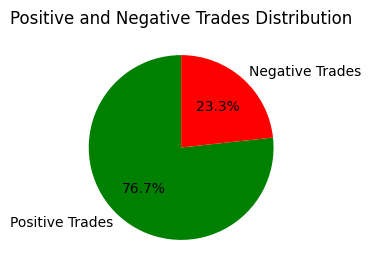

In [7]:
labels = ['Positive Trades', 'Negative Trades']
sizes = [positive_trades.shape[0], negative_trades.shape[0]]
colors = ['green', 'red']
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Positive and Negative Trades Distribution')
plt.show()

In [8]:
# trades_df

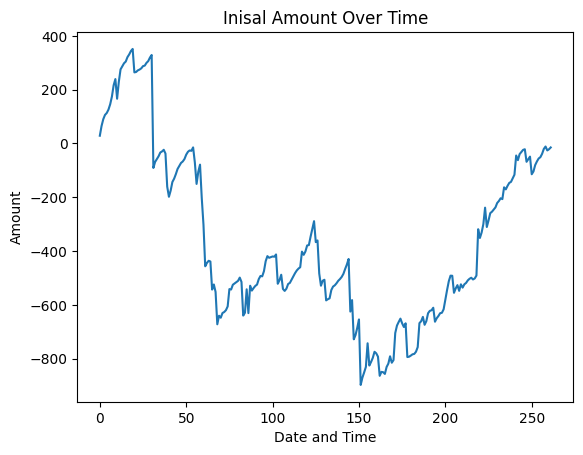

In [9]:
plt.plot(trades_df['Amount'])
plt.title('Inisal Amount Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Amount')
plt.show()